# IV.G - Timestamp Estimation

Code for generating the consistency heatmaps for the timestamp estimation of a single image

In [ ]:
# !pip install --upgrade scikit-image
# !pip install pyproj

### Imports & Definitions

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys

from itertools import product
import matplotlib.image as mpimg
import pyproj

from skimage import transform

sys.path.append("../../datasets")
from dataLoader import DataLoader, preprocess_time

from tf.keras.models import Model, load_model
from tf.keras.layers import Input
from tf.keras.losses import mean_squared_error

transLabels = ["dirty", "daylight", "night", "sunrisesunset", "dawndusk", "sunny", "clouds", 
               "fog", "storm", "snow", "warm", "cold", "busy", "beautiful", "flowers", "spring", 
               "summer", "autumn", "winter", "glowing", "colorful", "dull", "rugged", "midday", 
               "dark", "bright", "dry", "moist", "windy", "rain", "ice", "cluttered", "soothing", 
               "stressful", "exciting", "sentimental", "mysterious", "boring", "gloomy", "lush"]


batchSize = 1
pathToModel = "../IV.B_ablation_study/denseNet/gr_oh_loc_time_TA/weights.30-0.57407.hdf5"
gpuNumber = 4

## GPU selection
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[gpuNumber], 'GPU')
tf.config.experimental.set_memory_growth(gpus[gpuNumber], False)



#######################
##    Custom MSE     ##
#######################
# We will compute the MSE only for the consistent inputs
def transient_mse(y_true, y_pred):
    return tf.sum(mean_squared_error(y_true[0::2,:], y_pred[0::2,:]), axis=-1)



#######################
## Deprocess time
#######################
def deprocess_time(time):
    month, hour = time
    month = (11.0 / 2.0) * (month + 1) + 1
    hour = (23.0 / 2.0) * (hour + 1)
    return (int(round(month)), int(round(hour)))

def deprocess_loc(loc):
    _earth_radius = 6378137.0
    x,y,z = loc
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    
    lon, lat, alt = pyproj.transform(ecef, lla, x * _earth_radius, y*_earth_radius, z*_earth_radius, radians=False)
    return (lat, lon, alt)

### Load architecture and get pointers to specific layers
As we will process the features from multiple timestamps, we avoid re-processing the features for the ground-level image, location, and satellite image

In [5]:
baseModel = load_model(pathToModel, custom_objects={"transient_mse": transient_mse})
print(baseModel.summary())

groundBranchModel = Model(baseModel.get_layer("groundInput").input, 
                          baseModel.get_layer("batch_normalization_2").output)
aerialBranchModel = Model(baseModel.get_layer("aerialInput").input, 
                          baseModel.get_layer("batch_normalization_4").output)
locBranchModel = Model(baseModel.get_layer("locationInput").input, 
                       baseModel.get_layer("batch_normalization_7").output)
timeBranchModel =  Model(baseModel.get_layer("timeInput").input, 
                         baseModel.get_layer("batch_normalization_10").output)


combinedFeaturesInput = Input(shape=(512,), name='concatenate_1_proxy')
combinedFeatures = baseModel.get_layer("consist_fc1")(combinedFeaturesInput)
combinedFeatures = baseModel.get_layer("batch_normalization_11")(combinedFeatures)
combinedFeatures = baseModel.get_layer("consist_fc2")(combinedFeatures)
combinedFeatures = baseModel.get_layer("batch_normalization_12")(combinedFeatures)
combinedFeatures = baseModel.get_layer("consist_fc3")(combinedFeatures)
combineModel = Model(combinedFeaturesInput, combinedFeatures)

--------------
--------------
--------------
--------------


### Predicting the consistency probability for all hours and months

The `skipCount` variable allows us to control which image would be selected (without needing to adapt much of the dataLoader)

In [15]:
dl = DataLoader("test", 
                includeLocation = True, 
                includeSatellite = True, 
                outputTransientAttributes = True)

skipCount = 10

for batch, _ in dl.loadTestDataInBatches(batchSize, allTestSet=False):
    if skipCount >= 1:
        skipCount-=1
        continue
    
    grImg, aeImg, locInfo, timeInfo = [batch[i][0:1] for i in range(len(batch))]
    
    dLoc = deprocess_loc(locInfo[0])
    timeInfo = deprocess_time(timeInfo[0])

    grFeatures = groundBranchModel.predict_on_batch(grImg)
    aeFeatures = aerialBranchModel.predict_on_batch(aeImg)
    locFeatures = locBranchModel.predict_on_batch(locInfo)
    dLoc = deprocess_loc(locInfo[0])
    

    timeList, predList = [], []
    for month, hour in product(range(1,13), range(24)):
        timeFeatures = timeBranchModel.predict_on_batch(preprocess_time((month, hour)).reshape(1,-1))
        
        concatFV = np.hstack((grFeatures, aeFeatures, locFeatures, timeFeatures))
        pred = consistModel.predict_on_batch(concatFV)
        consistentProb = pred[0][0]
                
        timeList += [(month, hour)]
        predList += [consistentProb]
    break
    

sortedTimeList = [(y,x) for y,x in sorted(zip(predList,timeList), 
                                              key=lambda pair: pair[0], reverse=True)]
sortedProbs = [l[0] for l in sortedTimeList]
sortedTimes = [l[1] for l in sortedTimeList]

((1, 224, 224, 3), (1, 224, 224, 3), (1, 3), (1, 2))
((7, 2), (45.46370000000002, 9.18814, -9.313225746154785e-10))
('Correct time: ', (7, 2))
('Top 1% times: ', [])
('Top 5% times: ', [])
('Top 5% pred: ', [], '\n')


Given the location (`dLoc`), we shifted the heatmap based on the timeZone to present it as local time rather than UCT. 

In [ ]:
print(dLoc)

timeZone = +1  #Should change this considering the timeZone

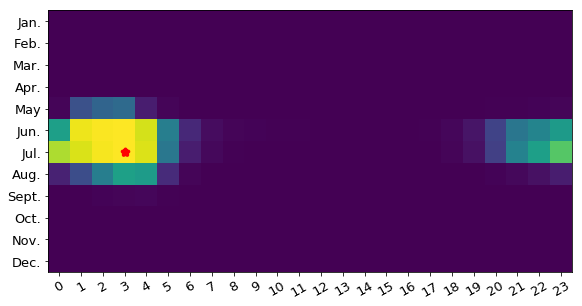

In [17]:
adjustedHeatMapMatrix = np.zeros((12, 24))
for i in range(len(sortedTimes)):
    month, hour = sortedTimes[i]
    adjustedHeatMapMatrix[month-1,((hour + timeZone)%24)] = sortedProbs[i]
    
    
fig=plt.figure(figsize=(8,8))
columns = 1
rows = 1

fig.add_subplot(rows, columns, 1)
fig.tight_layout()


plt.xticks(range(0,24), range(0,24), rotation=30, size=13)
plt.yticks(range(0,13), 
           ["Jan.", "Feb.", "Mar.", "Apr.", "May", "Jun.", "Jul.", "Aug.", "Sept.", "Oct.", "Nov.", "Dec."],
           size=13)
plt.scatter((timeInfo[1]+timeZone)%24, timeInfo[0]-1, lw=4, c='r', marker="*")
plt.imshow(adjustedHeatMapMatrix, cmap='viridis')

plt.show()